# Download weather data

This file downloads weather data from the [Deutscher Wetterdienst](https://www.dwd.de/DE/Home/home_node.html) using [this Dataset](https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/air_temperature/).

In [1]:
# basich imports
import pandas as pd
from tqdm import tqdm
import requests
from bs4 import BeautifulSoup
import re
import numpy as np
import zipfile
import os
from datetime import datetime

In [2]:
urls = [
    "https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/air_temperature/historical/",
    "https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/air_temperature/recent/"
]

In [3]:
all_links = []
all_ids = dict()
for url in urls:
    r = requests.get(url)

    historical_listing = BeautifulSoup(r.content, "html.parser")

    a_tags = historical_listing.find_all("a", href=re.compile("stundenwerte"))

    links = list(map(lambda x: url + x["href"], a_tags))
    all_links += links
    
    ids = map(lambda x: re.findall("TU_([0-9]*)_", x)[0], links)
    name = re.findall("([a-z]*)/$", url)[0]
    all_ids[name] = set(ids)

We will only consider data, for which we can get historical and recent data

In [4]:
valid_ids = list(all_ids["recent"].intersection(all_ids["historical"]))
print(valid_ids[:10])

['01451', '05731', '07351', '03987', '01473', '05229', '05099', '05676', '05717', '04896']


Now that we have all the links to all the data, we can start downloading. In order to keep size managable and not overwhelm the server we will just download a couple of files. This should be fine, since we are only interested in a temperature average in Germany.

In [5]:
data = pd.DataFrame()

N = 25

np.random.seed(42)
ids = np.random.choice(valid_ids, N, replace=False)

links = list(filter(
    lambda x: re.findall("TU_([0-9]*)_", x)[0] in ids,
    all_links
))

for link in tqdm(links):
    r = requests.get(link)

    # ZipFile can apparently not ready directly from a bytestring, so we have to save it first...
    with open("temp.zip", "wb") as zf:
        zf.write(r.content)

    # and then load it as a ZipFile
    with zipfile.ZipFile("temp.zip", "r") as zf:
        infos = zf.infolist()
        filename = ""
        for info in infos:
            if re.findall("^produkt", info.filename):
                filename = info.filename
                break

        data = data.append(
            pd.read_csv(
                zf.open(filename), 
                delimiter=";",
                date_parser=lambda x: datetime.strptime(x, "%Y%m%d%H"),
                parse_dates=["MESS_DATUM"]
            )
        )
os.remove("temp.zip") # finally remove the temporary file

100%|██████████| 50/50 [01:38<00:00,  1.98s/it]


Now that we have the data, we can slim it down by averaging over all measurements and restricting ourselves to data newer that 2020-01-01.

Also we will remove outliers (smaller than -60, which would be very unlikely).

In [6]:
data.rename(columns={"MESS_DATUM": "date"}, inplace=True)
data["TT_TU"] = data["TT_TU"].apply(lambda x: np.nan if x < -60 else x)
data_slimmed = data.groupby("date").mean()[["TT_TU"]]
data_slimmed.rename(columns={"TT_TU": "air temperature"}, inplace=True)
data_slimmed = data_slimmed[data_slimmed.index > datetime.strptime("20190101", "%Y%m%d")] # keep data starting 2019, as we will need that later

data_slimmed.head()

,air temperature
date,
2019-01-01 01:00:00,6.504000
2019-01-01 02:00:00,6.358333
2019-01-01 03:00:00,6.258333
2019-01-01 04:00:00,6.141667
2019-01-01 05:00:00,6.070833


Now that we have the data as we want it, we can take a quick look at if this looks reasonable

In [7]:
import matplotlib.pyplot as plt

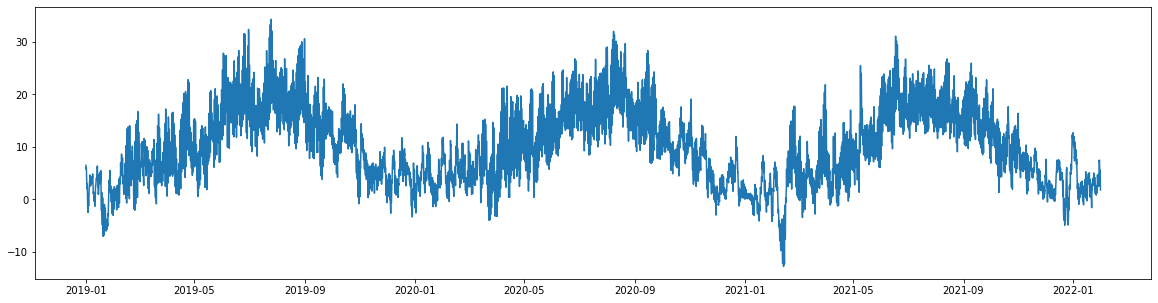

In [8]:
plt.figure(figsize=(20, 5))
plt.plot(data_slimmed.index, data_slimmed["air temperature"])
plt.show()

Now we will resample the data, in order to be gauranteed, that we have all datapoints (hourly, since 2020-01-01), and fill missing values by interpolation.

In [9]:
data_final = data_slimmed.resample("H").asfreq()
data_final = data_final.interpolate()

Finally we can save the data:

In [10]:
data_final.to_csv("../dat/WeatherData.csv")